Projeto final -- 
Conjunto de Dados de Previsão de Estoque de Loja de Varejo;

Origem dos dados: Kaggle;

Analista : Igor T G Silva;

Professor: Fernando Calabria;

Finalização do Cientista de dados, escola Treina Recife.

In [15]:
# Imports para manipulação de dados
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, exc

#Import para tratamento de datas
from datetime import datetime, timedelta

# Imports para visualização de dados
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as m
import seaborn as sns

# Imports para análise e modelagem de séries temporais
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Importações do scikit-learn
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning


# Imports para métricas e performance do modelo
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random
from sklearn.neural_network import MLPRegressor

from sklearn.inspection import permutation_importance


# Filtra os warnings
import warnings
warnings.filterwarnings('ignore')




In [16]:
print("Iniciando a importação dos dados")
print("Utilizaremos o data set: Retail Store Inventory Forecasting Dataset")

print("PROCESSAMENTO DE DADOS:")

try:
    Df_dados = pd.read_csv(r"G:\Meu Drive\TreinaRecife\Modulo2 - Estatistica para ciencia de dados\ProfetoFinal\retail_store_inventory.csv",
                           sep=',')
    print("Importação concluída com sucesso!")
except Exception as e:
    print("Erro ao importar os dados:", e)


Iniciando a importação dos dados
Utilizaremos o data set: Retail Store Inventory Forecasting Dataset
PROCESSAMENTO DE DADOS:
Importação concluída com sucesso!


In [17]:
print('Iniciando a fase de ETL: extração, tratamento e limpeza de dados')
print('Extração: Carregar os dados através do arquivo CSV')
print('Transformação: tratar valores ausentes, correção de dados, \ncriação de variáveis derivadas e filtragem de colunas')
print('Carga: Preparar o df para análise e modelagem')

# Criaremos uma cópia para iniciar o processo de ETL:
Df_Analise1 = Df_dados.copy()

# Visão Geral:
print("Principais informações do DataFrame:")
Df_Analise1.info()

print("\nAnálise descritiva de dados:")
print(Df_Analise1.describe())

print("\nDimensões:")
print(Df_Analise1.shape)

print("\nColunas:")
print(Df_Analise1.columns.tolist())

print("\nTipos de dados:")
print(Df_Analise1.dtypes)

print("\nValores ausentes por coluna:")
print(Df_Analise1.isnull().sum())



Iniciando a fase de ETL: extração, tratamento e limpeza de dados
Extração: Carregar os dados através do arquivo CSV
Transformação: tratar valores ausentes, correção de dados, 
criação de variáveis derivadas e filtragem de colunas
Carga: Preparar o df para análise e modelagem
Principais informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null

In [18]:
# Iniciando preparação do data frame:

print("Iniciando a fase de transformação do df, \nvamos alterar o tipo de index, \nalterar o nome de algumas colunas e \nfiltrar o necessario para o df.")

try:
    print("Criando a coluna: valor_total_vendido")
    Df_Analise1['Faturamento'] = Df_Analise1['Units Sold']*Df_Analise1['Price']
    
    print("Mudando o nome das colunas para o Portugues")
    map_names_columns = {
        'Date':'Data',
        'Store ID':'ID_filial',
        'Product ID':'ID_produto',
        'Category':'Categoria',
        'Region':'Regiao',
        'Inventory Level':'Nivel_estoque',
        'Units Sold':'Unidades_vendidas',
        'Units Ordered':'Unidades_perdidas',
        'Demand Forecast':'Previsao_demanda',
        'Price':'Preço',
        'Discount':'Desconto',
        'Weather Condition':'Condicao_climatica',
        'Holiday/Promotion':'Feriado/Promocao',
        'Competitor Pricing':'Preco_concorrencia',
        'Seasonality':'Sazonalidade'
    }
    
    Df_Analise1.rename(columns=map_names_columns,inplace=True)
    
    if 'Data' in Df_Analise1.columns:
        Df_Analise1['Data'] = pd.to_datetime(Df_Analise1['Data'], format='%Y-%m-%d')
        Df_Analise1.set_index('Data', inplace=True) 
        Df_Analise1.sort_index(inplace=True)
    else: 
         print('Erro! Coluna "Data" não encontrada.')
         
    # Tratamento e Preparação FinaL
    
    duplicadas = Df_Analise1.duplicated().sum()
    print(f"Linhas duplicadas: {duplicadas}")
    Df_Analise1.drop_duplicates(inplace=True)
    
    # Verificar e corrigir tipos de dado
    
    categorias = ['ID_filial', 'ID_produto', 'Categoria', 'Regiao', 'Condicao_climatica', 'Feriado/Promocao', 'Sazonalidade']
    for col in categorias:
        Df_Analise1[col] = Df_Analise1[col].astype('category')
    
    # Criando variaveis de tempo
    Df_Analise1['Ano'] = Df_Analise1.index.year
    Df_Analise1['Mes'] = Df_Analise1.index.month
    Df_Analise1['Dia_semana'] = Df_Analise1.index.day_name()
    
    # Codificar variáveis categórica
    
    Df_modelagem = pd.get_dummies(Df_Analise1, drop_first=True)
except Exception as e:
    print('Erro:',e)
    
# Objetivo do projeto:
# Prever o nível de estoque e analisar seu impacto no faturamento total da loja.
# A ideia é entender se o estoque atual é suficiente para manter, aumentar ou reduzir o faturamento.

# Nesta etapa, preparamos o DataFrame para modelagem:
# - Criamos a variável 'Faturamento' como produto entre unidades vendidas e preço.
# - Padronizamos os nomes das colunas para facilitar a leitura e manipulação.
# - Ajustamos o índice para a coluna de data, permitindo análises temporais.
# - Eliminamos duplicatas para garantir integridade dos dados.
# - Convertidas colunas categóricas para o tipo 'category' e aplicamos one-hot encoding.
# - Derivamos variáveis temporais úteis para análise de sazonalidade e comportamento de vendas.

Iniciando a fase de transformação do df, 
vamos alterar o tipo de index, 
alterar o nome de algumas colunas e 
filtrar o necessario para o df.
Criando a coluna: valor_total_vendido
Mudando o nome das colunas para o Portugues
Linhas duplicadas: 0


Selecionando apenas variaveis numericas do Df

Matriz de correlação

Vizualizando a matriz:


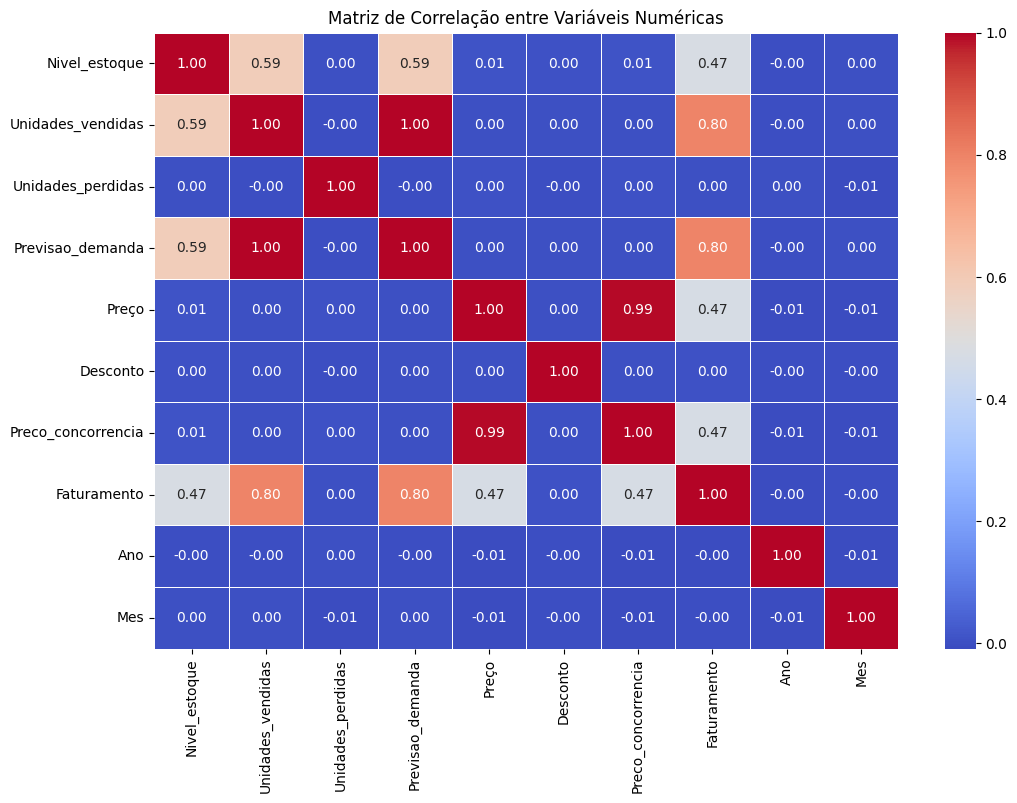

A correlação sendo positiva significativa (ex: acima de 0.5), 
isso indica que quanto maior o estoque, maior tende a ser o volume de vendas. 
Isso pode refletir boa reposição ou disponibilidade de produtos.


In [19]:
# Verifianco a possibilidade de correlação entre as variaveis:

print("Selecionando apenas variaveis numericas do Df")
Df_numeric = Df_modelagem.select_dtypes(include=['float64','int64','int32','object'])

print("\nMatriz de correlação")
Matriz_corr = Df_numeric.corr()

print("\nVizualizando a matriz:")
plt.figure(figsize=(12,8))
sns.heatmap(Matriz_corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.show()

print('A correlação sendo positiva significativa (ex: acima de 0.5), \nisso indica que quanto maior o estoque, maior tende a ser o volume de vendas. \nIsso pode refletir boa reposição ou disponibilidade de produtos.')

#  Essas correlações mostram que o estoque não está isolado: ele responde a fatores operacionais (previsão) e afeta resultados (vendas). 



Calculando a correlação...
Filtra variáveis com correlação significativa...
Criando o dataframe...
Erro: "['Dia_semana'] not in index"

Vizualizando a matriz:


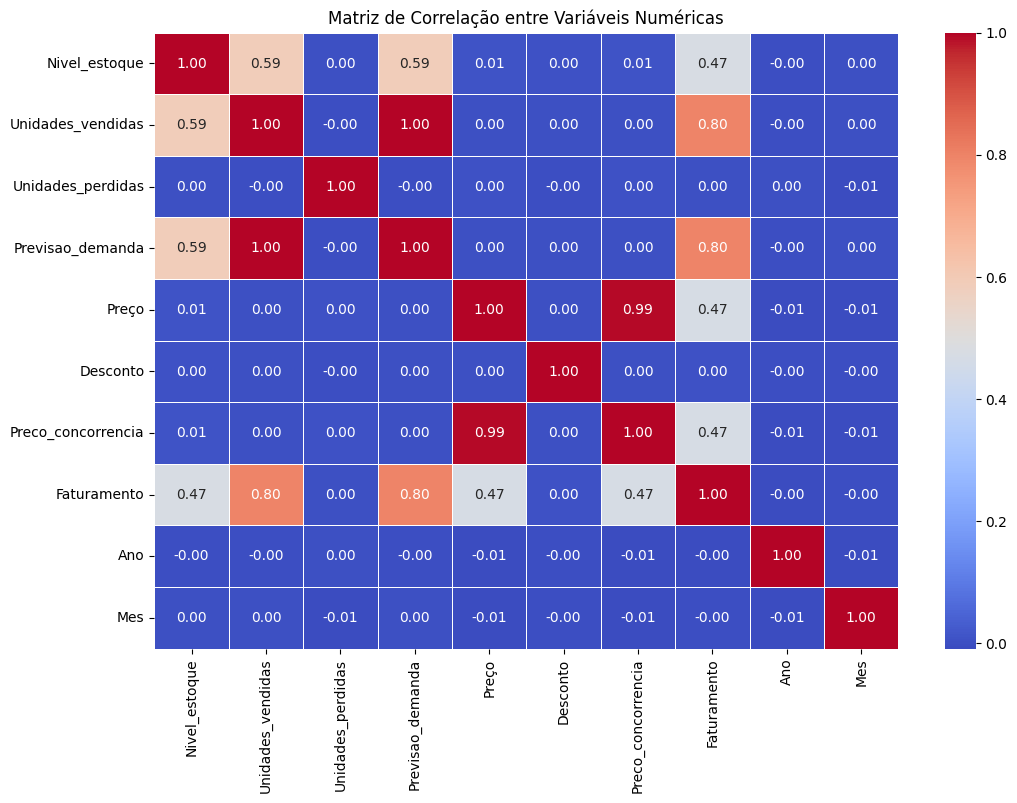

Informações importantes:

Correlações com a 1variavel alvo: Unidades_vendidas,Previsao_demanda e Faturamento
Multicolinearidade:
Unidades_vendidas e Previsao_demanda, tem correlação 1.00, para não causar redundancia vamos usar apenas Unidades_vendidas.


In [20]:
# Criando data frame com as variaveis com mais correlações;

try:
    print("Calculando a correlação...")
    corrrelacao = Df_numeric.corr()['Nivel_estoque'].abs()
    print("Filtra variáveis com correlação significativa...")
    limiar = 0.3
    variaveis_relevantes = corrrelacao[corrrelacao>limiar].index.tolist()
    print("Criando o dataframe...")
    Df_fin = Df_numeric[['Nivel_estoque','Unidades_vendidas', 'Faturamento', 'Ano', 'Mes', 'Dia_semana']]
    print("Processo finalizado com sucesso!")
except Exception as e:
    print("Erro:",e)

# Vizualizando a correlação:
Matriz_corr_3 = Df_numeric.corr()
print("\nVizualizando a matriz:")
plt.figure(figsize=(12,8))
sns.heatmap(Matriz_corr_3, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.show()

print("Informações importantes:")
print("\nCorrelações com a 1variavel alvo: Unidades_vendidas,Previsao_demanda e Faturamento")
print("Multicolinearidade:")
print("Unidades_vendidas e Previsao_demanda, tem correlação 1.00, para não causar redundancia vamos usar apenas Unidades_vendidas.")
# Etapa de seleção automática de variáveis com correlação significativa com 'Nivel_estoque':
# - Calculada a correlação absoluta entre todas as variáveis numéricas e 'Nivel_estoque'.
# - Definido limiar de 0.3 para considerar correlações moderadas ou fortes.
# - Criado o DataFrame `Df_fin` contendo apenas variáveis com potencial explicativo.

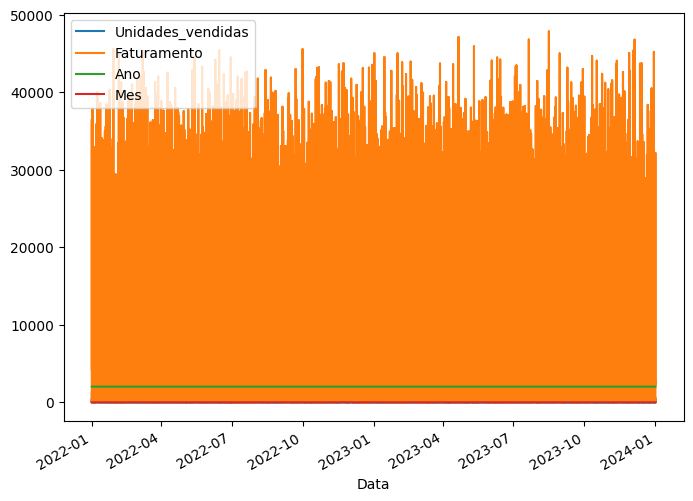

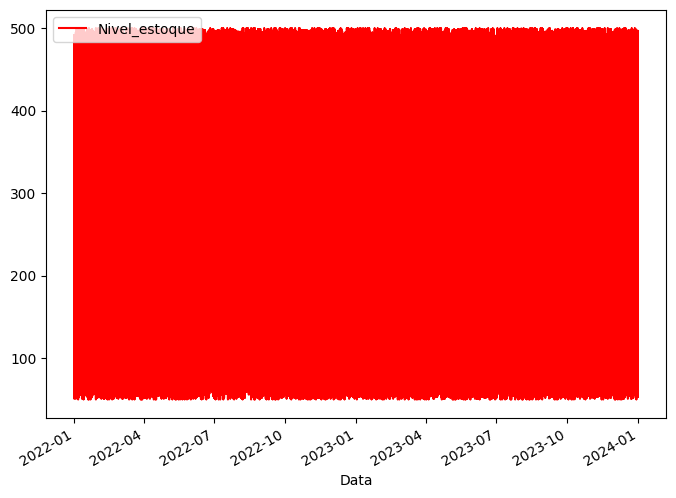

- Faturamento apresenta valores mais altos e mais frequentes, dominando visualmente o gráfico
- Unidades_vendidas tem menor amplitude, mas acompanha a dinâmica do faturamento em vários trechos.


In [21]:
# Vamos dividir o Dta frame Df_fin entre variaveis exogenas e endogenas:

try:
    
    Var_exogena = pd.DataFrame(Df_numeric[['Unidades_vendidas','Faturamento','Ano', 'Mes']])
    Var_endogena = pd.DataFrame(Df_numeric['Nivel_estoque'])
except Exception as e:
    print("Erro:",e)
    
Var_exogena.plot(figsize=(8,6))
Var_endogena.plot(figsize=(8,6),color='red')
plt.show()

print("- Faturamento apresenta valores mais altos e mais frequentes, dominando visualmente o gráfico")
print('- Unidades_vendidas tem menor amplitude, mas acompanha a dinâmica do faturamento em vários trechos.')
    

In [22]:
'''
✅ Por que aplicaremos programação genetica na série temporal?
- O modelo tem variáveis exógenas, sazonalidade, e comportamento complexo
- Podemos encontrar ordens ideais (p,d,q) para SARIMAX, ou melhores configurações de regressoras no Prophet
- Pode testar cenários que seriam difíceis de explorar manualmente
'''
print('Iniciano:')
try:
    X = Var_exogena
    y = Var_endogena
    
    # Dividiremos em treino e teste;
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Escalonar os dados para um melhor desempenho da Rede Neural
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"Dataset carregado: {X.shape[0]} amostras, {X.shape[1]} features.")
    print(f"Conjuntos de treino/teste: {X_train_scaled.shape[0]}/{X_test_scaled.shape[0]} amostras.")
    
    # --- . Definição dos Parâmetros da Rede Neural e Mapeamentos ---
    # Mapeamentos para os parâmetros categóricos
    ACTIVATION_FUNCTIONS = ['relu', 'tanh', 'logistic']
    SOLVERS = ['adam', 'sgd', 'lbfgs']

    # Faixas para os parâmetros numéricos
    MIN_NEURONS = 10
    MAX_NEURONS = 200
    MIN_ALPHA = 0.0001
    MAX_ALPHA = 0.01
    MIN_LEARNING_RATE = 0.0001
    MAX_LEARNING_RATE = 0.01

    # --- . Configuração do DEAP para o Algoritmo Genético ---

    print('Definindo uma função que receba os parâmetros e retorne uma métrica de desempenho (ex: RMSE, R²):')

    def avaliar_individuo(individuo):
        n_neurons, alpha, learning_rate, activation_idx, solver_idx = individuo

        activation = ACTIVATION_FUNCTIONS[int(activation_idx)]
        solver = SOLVERS[int(solver_idx)]

        modelo = MLPRegressor(
        hidden_layer_sizes=(int(n_neurons),),
        alpha=alpha,
        learning_rate_init=learning_rate,
        activation=activation,
        solver=solver,
        max_iter=100,
        random_state=42
        )   
        try:
            modelo.fit(X_train_scaled, y_train.values.ravel())
            y_pred = modelo.predict(X_test_scaled)
            rmse = np.sqrt(np.mean((y_test.values.ravel() - y_pred)**2))
        except Exception as e:
            rmse = 1e6


        return (rmse,)

    print('Configurando o espaço genetico:')
    
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimizar RMSE
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    # Genes: [neurons, alpha, learning_rate, activation_idx, solver_idx]
    toolbox.register("n_neurons", random.randint, MIN_NEURONS, MAX_NEURONS)
    toolbox.register("alpha", random.uniform, MIN_ALPHA, MAX_ALPHA)
    toolbox.register("learning_rate", random.uniform, MIN_LEARNING_RATE, MAX_LEARNING_RATE)
    toolbox.register("activation_idx", random.randint, 0, len(ACTIVATION_FUNCTIONS)-1)
    toolbox.register("solver_idx", random.randint, 0, len(SOLVERS)-1)

    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.n_neurons, toolbox.alpha, toolbox.learning_rate,
                      toolbox.activation_idx, toolbox.solver_idx), n=1)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    print('Configurando operador genetico')
    
    toolbox.register("evaluate", avaliar_individuo)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    print('Executando o algoritmo genetico')
    
    pop = toolbox.population(n=10)
    hof = tools.HallOfFame(1)

    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, halloffame=hof, verbose=True)

    melhor_individuo = hof[0]
except Exception as e:
    print("Erro:",e)

Iniciano:
Dataset carregado: 73100 amostras, 4 features.
Conjuntos de treino/teste: 51170/21930 amostras.
Definindo uma função que receba os parâmetros e retorne uma métrica de desempenho (ex: RMSE, R²):
Configurando o espaço genetico:
Configurando operador genetico
Executando o algoritmo genetico
gen	nevals
0  	10    
1  	10    
2  	6     
3  	2     
4  	9     
5  	6     
6  	6     
7  	0     
8  	8     
9  	5     
10 	8     


In [23]:
# Etapa 1: Decodificação dos parâmetros do melhor indivíduo
# O algoritmo genético armazenou no Hall of Fame o indivíduo com menor RMSE.
# Este bloco extrai os hiperparâmetros otimizados para treinar o modelo final.


melhor = melhor_individuo
n_neurons = int(melhor[0])
alpha = melhor[1]
learning_rate = melhor[2]
activation = ACTIVATION_FUNCTIONS[int(melhor[3])]
solver = SOLVERS[int(melhor[4])]

print("Melhor configuração encontrada:")
print(f"Neurônios: {n_neurons}, Alpha: {alpha:.5f}, Learning Rate: {learning_rate:.5f}")
print(f"Ativação: {activation}, Solver: {solver}")


Melhor configuração encontrada:
Neurônios: 129, Alpha: 0.00883, Learning Rate: 0.00750
Ativação: tanh, Solver: adam


In [24]:
# Etapa 2: Treinamento do modelo final com os melhores parâmetros
# O modelo MLPRegressor é treinado com os dados escalonados e os hiperparâmetros otimizados.

modelo_final = MLPRegressor(
    hidden_layer_sizes=(n_neurons),
    alpha=alpha,
    learning_rate_init=learning_rate,
    activation=activation,
    solver=solver,
    max_iter=300,
    random_state=42
)

modelo_final.fit(X_train_scaled,y_train.values.ravel())
y_pred_final = modelo_final.predict(X_test_scaled)

# Etapa 3: Avaliação do desempenho preditivo
# São calculadas as métricas RMSE e R² para avaliar a qualidade do modelo final.

rmse_final = np.sqrt(mean_squared_error(y_test.values.ravel(),y_pred_final))
r2_final = r2_score(y_test.values.ravel(),y_pred_final)

In [25]:
# Etapa 3: Avaliação do desempenho preditivo
# São calculadas as métricas RMSE e R² para avaliar a qualidade do modelo final.

rmse_final = np.sqrt(mean_squared_error(y_test.values.ravel(),y_pred_final))
r2_final = r2_score(y_test.values.ravel(),y_pred_final)

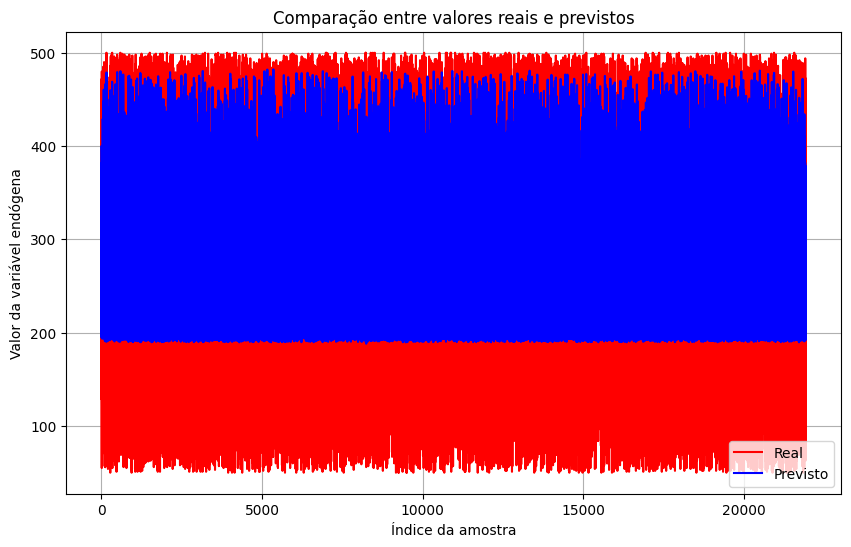

Se o modelo prevê corretamente o nível de estoque, isso permite:
Antecipar rupturas (estoque abaixo do mínimo
Evitar excesso de armazenagem (estoque acima do necessário
Ajustar compras e reposições com base em demanda futura
Simular cenários com variáveis exógenas como promoções, sazonalidade ou eventos

Acurva azul (previsto) está consistentemente acima da vermelha (real), isso pode indicar:
O modelo está superestimando o nível de estoque
Pode haver um viés nos dados ou nos hiperparâmetros
Talvez o modelo esteja captando tendência de reposição, mas não está ajustado para quedas abruptas de consumo


In [26]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values.ravel(), label='Real', color='red')
plt.plot(y_pred_final, label='Previsto', color='blue')
plt.title("Comparação entre valores reais e previstos")
plt.xlabel("Índice da amostra")
plt.ylabel("Valor da variável endógena")
plt.legend()
plt.grid(True)
plt.show()

print('Se o modelo prevê corretamente o nível de estoque, isso permite:')
print('Antecipar rupturas (estoque abaixo do mínimo')
print('Evitar excesso de armazenagem (estoque acima do necessário')
print('Ajustar compras e reposições com base em demanda futura')
print('Simular cenários com variáveis exógenas como promoções, sazonalidade ou eventos')

print('\nAcurva azul (previsto) está consistentemente acima da vermelha (real), isso pode indicar:')
print('O modelo está superestimando o nível de estoque')
print('Pode haver um viés nos dados ou nos hiperparâmetros')
print('Talvez o modelo esteja captando tendência de reposição, mas não está ajustado para quedas abruptas de consumo')




Unidades_vendidas: 0.6743
Faturamento: 0.0027
Ano: -0.0002
Mes: -0.0002


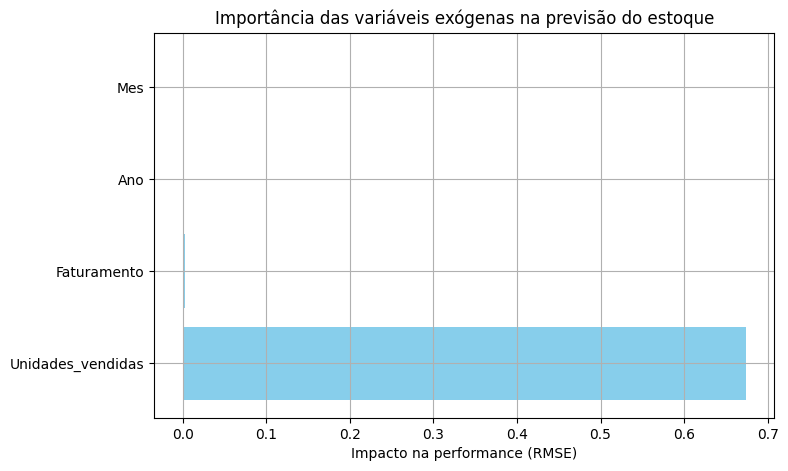

A análise mostra que o modelo está baseado em comportamento real de consumo, e não apenas em datas ou valores financeiros.
Isso é ótimo para aplicações logísticas e planejamento de reposição.


In [31]:
from sklearn.inspection import permutation_importance

resultado_importancia = permutation_importance(modelo_final, X_test_scaled, y_test.values.ravel(), n_repeats=10, random_state=42)

importancia = resultado_importancia.importances_mean
nomes_features = X.columns

for nome, imp in zip(nomes_features, importancia):
    print(f"{nome}: {imp:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(nomes_features, importancia, color='skyblue')
plt.title("Importância das variáveis exógenas na previsão do estoque")
plt.xlabel("Impacto na performance (RMSE)")
plt.grid(True)
plt.show()
print('A análise mostra que o modelo está baseado em comportamento real de consumo, e não apenas em datas ou valores financeiros.')
print('Isso é ótimo para aplicações logísticas e planejamento de reposição.')

In [34]:
# Como montar esse DataFrame final para gerar as vizualizações no power bi. 

df_resultado = pd.DataFrame({
    'Nivel_estoque_real': y_test.values.ravel(),
    'Nivel_estoque_previsto': y_pred_final,
    'Erro_absoluto': np.abs(y_test.values.ravel() - y_pred_final),
    'Unidades_vendidas': X_test['Unidades_vendidas'].values,
    'Faturamento': X_test['Faturamento'].values,
    'Ano': X_test['Ano'].values,
    'Mes': X_test['Mes'].values
})

df_resultado.to_excel('Df_resultado.xlsx', index=False)